In [0]:
!mkdir -p ~/.kaggle/

In [0]:
mv kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

 98% 329M/334M [00:04<00:00, 56.0MB/s]
100% 334M/334M [00:05<00:00, 70.1MB/s]


In [0]:
!unzip -q lgg-mri-segmentation.zip

In [5]:
!pip install -q tensorflow-gpu==2.0.0-alpha0

     |████████████████████████████████| 332.1MB 52kB/s 
     |████████████████████████████████| 3.0MB 26.9MB/s 
     |████████████████████████████████| 419kB 52.8MB/s 


In [0]:
import tensorflow as tf

In [7]:
tf.__version__

'2.0.0-alpha0'

In [8]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import layers
from tensorflow.python.keras.utils.data_utils import Sequence

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler

from keras.preprocessing import image

from sklearn.model_selection import train_test_split

from skimage.transform import resize

import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import shutil
import PIL
import pathlib
import pandas as pd
import cv2
from imgaug import augmenters as iaa
import imgaug as ia

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import itertools

import re

Using TensorFlow backend.


In [0]:
!mv kaggle_3m/README.md ./

In [0]:
!mv kaggle_3m/data.csv ./

In [0]:
patients_folders = os.listdir("kaggle_3m")

In [12]:
len(patients_folders)

110

In [0]:
!mkdir files

In [0]:
!mkdir files/masks && mkdir files/images

In [0]:
for folder in patients_folders:
  files = os.listdir(f'kaggle_3m/{folder}')
  
  for file in sorted(files):
    file_url = f'kaggle_3m/{folder}/{file}'
    
    if "mask" in file:
      shutil.move(file_url, "files/masks")
    else:
      shutil.move(file_url, "files/images")

In [0]:
images_paths = os.listdir("files/images")

In [17]:
len(images_paths)

3929

In [0]:
val_size = int(len(images_paths) * .20)

In [19]:
val_size

785

In [0]:
X_train = images_paths[val_size:]
X_val = images_paths[:val_size]

In [21]:
len(X_train), len(X_val)

(3144, 785)

## Generator

In [0]:
class DataGenerator(Sequence):
    def __init__(self, images_paths, batch_size=32, validation=False, predict=False, shuffle=True):
      self.batch_size = batch_size
      self.images_paths = images_paths
      self.shuffle = shuffle
      self.validation = validation
      self.predict = predict
      self.on_epoch_end()

    def __len__(self):
      return int(np.floor(len(self.images_paths) / self.batch_size))

    def __getitem__(self, index):
      from_range = index * self.batch_size
      to_range = (index + 1) * self.batch_size
      indexes = self.indexes[from_range:to_range]
      
      if self.predict:
        X = self.__load_predict__(indexes)
        return X
      
      else:
        X, y = self.__load__(indexes)
        return X, y

    def on_epoch_end(self):
      self.indexes = np.arange(len(self.images_paths))
      
      if self.shuffle == True:
          np.random.shuffle(self.indexes)
    
    def __load_image__(self, index):
      image_path = self.images_paths[index]
  
      image_loaded = image.load_img(f'files/images/{image_path}')
      image_loaded = image.img_to_array(image_loaded)
      image_loaded = resize(image_loaded, (input_shape), mode='constant', preserve_range=True)
      
      image_loaded = image_loaded / 255.0
      
      return image_loaded
    
    def __load_image_and_mask__(self, index):
      image_path = self.images_paths[index]
      mask_path = image_path[:-4] + "_mask.tif"
  
      image_loaded = image.load_img(f'files/images/{image_path}')
      image_loaded = image.img_to_array(image_loaded)
      image_loaded = resize(image_loaded, (input_shape), mode='constant', preserve_range=True)

      mask_loaded = image.img_to_array(image.load_img(f'files/masks/{mask_path}', color_mode="grayscale"))
      mask_loaded = resize(mask_loaded, (img_size, img_size, 1), mode='constant', preserve_range=True)
      
      image_loaded = image_loaded / 255.0
      mask_loaded = mask_loaded / 255.0
      
      return image_loaded, mask_loaded
    
    def __load_predict__(self, indexes):
      X = []
      
      for index in indexes:
        img = self.__load_image__(index)
        X.append(img)

      return np.array(X)
    
    def __load__(self, indexes):
      X = []
      y = []
      
      for index in indexes:
        img, mask = self.__load_image_and_mask__(index)
        X.append(img)
        y.append(mask)
      
      return np.array(X), np.array(y)

## Network

In [0]:
def downstream_block(layer, number_filters):
  layer = layers.Conv2D(number_filters, 3, activation='relu', padding="same")(layer)
  cropped_feature_map = layers.Conv2D(number_filters, 3, activation='relu', padding="same")(layer)
  layer = layers.MaxPool2D(2, strides=2, padding='same')(cropped_feature_map)
  
  return layer, cropped_feature_map

In [0]:
def upstream_block(layer, number_filters, cropped_feature_map):
  layer = layers.Conv2DTranspose(number_filters, (2, 2), strides=(2, 2), padding='same')(layer)
  layer = layers.concatenate([layer, cropped_feature_map])
  layer = layers.Conv2D(number_filters, 3, activation='relu', padding="same")(layer)
  layer = layers.Conv2D(number_filters, 3, activation='relu', padding="same")(layer)
  
  return layer

In [0]:
def u_net():
  input = layers.Input(input_shape)
  layer = input
  
  cropped_feature_maps = []
  
  for index in range(steps + 1):
    current_number_filters = number_filters * 2 ** index
    layer, cropped_feature_map = downstream_block(layer, current_number_filters)
    cropped_feature_maps.append(cropped_feature_map)
  
  layer = cropped_feature_maps.pop()
  
  for index in range(steps - 1, -1, -1):
    current_number_filters = number_filters * 2 ** index
    layer = upstream_block(layer, current_number_filters, cropped_feature_maps[index])
  
  output = layers.Conv2D(number_classes, 1, activation='sigmoid')(layer)
  model = Model(input, output)
  
  return model

In [0]:
input_shape = (256, 256, 3)
img_size = 256
number_filters = 16 
steps = 4
number_classes = 1

In [0]:
model = None
model = u_net()

In [0]:
batch_size = 32

learning_rate = 3e-4
epochs = 50

In [0]:
def polynomial_decay(epoch):
	power = 1.0
 
	alpha = learning_rate * (1 - (epoch / float(epochs))) ** power
	return alpha

In [0]:
weights_name = "epoch={epoch:02d}|accuracy={acc:.4f}|val_accuracy={val_acc:.4f}.h5"

checkpoint = ModelCheckpoint(weights_name, monitor="val_acc", verbose=1, save_best_only=True,
                                 save_weights_only=True, mode="max", period=1)

lr_decay = LearningRateScheduler(polynomial_decay)

In [0]:
model.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=['acc'])

In [0]:
train_steps = int(len(X_train) / batch_size)
val_steps = int(len(X_val) / batch_size)

In [33]:
train_steps, val_steps

(98, 24)

In [0]:
train_generator = DataGenerator(X_train, batch_size)
val_generator = DataGenerator(X_val, batch_size, validation=True)

In [0]:
trained_model = model.fit_generator(train_generator,
                        epochs=epochs,
                        steps_per_epoch=train_steps,
                        callbacks=[checkpoint, lr_decay],
                        validation_data=val_generator,
                        validation_steps=val_steps,
                        verbose=1)

Epoch 1/50
97/98 [============================>.] - ETA: 0s - loss: 0.2181 - acc: 0.9648
Epoch 00001: val_acc improved from -inf to 0.98868, saving model to epoch=01|accuracy=0.9650|val_accuracy=0.9887.h5
98/98 [==============================] - 66s 678ms/step - loss: 0.2163 - acc: 0.9650 - val_loss: 0.0369 - val_acc: 0.9887
Epoch 2/50
97/98 [============================>.] - ETA: 0s - loss: 0.0319 - acc: 0.9890
Epoch 00002: val_acc improved from 0.98868 to 0.98882, saving model to epoch=02|accuracy=0.9890|val_accuracy=0.9888.h5
98/98 [==============================] - 59s 601ms/step - loss: 0.0319 - acc: 0.9890 - val_loss: 0.0287 - val_acc: 0.9888
Epoch 3/50
97/98 [============================>.] - ETA: 0s - loss: 0.0289 - acc: 0.9890
Epoch 00003: val_acc did not improve from 0.98882
98/98 [==============================] - 59s 605ms/step - loss: 0.0288 - acc: 0.9891 - val_loss: 0.0280 - val_acc: 0.9887
Epoch 4/50
97/98 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 

In [0]:
model.load_weights("epoch=48_accuracy=0.9983_val_accuracy=0.9971.h5")

In [0]:
def print_image_and_masks(X, index):
  image_path = X[index]
  mask_path = image_path[:-4] + "_mask.tif"

  image_loaded = image.load_img(f'files/images/{image_path}')
  image_loaded = image.img_to_array(image_loaded)
  image_loaded = resize(image_loaded, (input_shape), mode='constant', preserve_range=True)
  
  mask_loaded = image.img_to_array(image.load_img(f'files/masks/{mask_path}', color_mode="grayscale"))
  mask_loaded = resize(mask_loaded, (img_size, img_size, 1), mode='constant', preserve_range=True)

  image_loaded = image_loaded / 255.0
  mask_loaded = mask_loaded / 255.0
  
  image_array = np.expand_dims(image_loaded, axis=0)
  
  predictions = model.predict(image_array)
  
  mask_predicted = predictions[0]
  
  has_mask = mask_loaded.max() > 0

  fig, ax = plt.subplots(1, 3, figsize=(10, 10))
  ax[0].imshow(image_loaded)

  if has_mask:
      ax[0].contour(mask_loaded.reshape(256, 256), colors='k', levels=[0.5])
  ax[0].set_title('Original image')

  ax[1].imshow(mask_loaded.reshape(256, 256))
  ax[1].set_title('True Mask')

  ax[2].imshow(mask_predicted.reshape(256, 256), vmin=0, vmax=1)

  if has_mask:
      ax[2].contour(mask_loaded.reshape(256, 256), colors='k', levels=[0.5])
  ax[2].set_title('Predicted Mask')

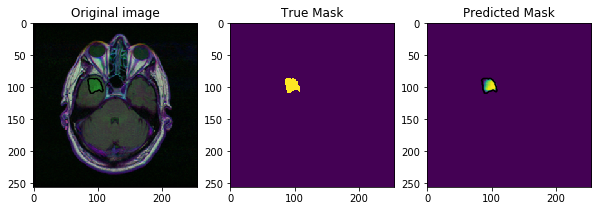

In [51]:
print_image_and_masks(X_train, 0)

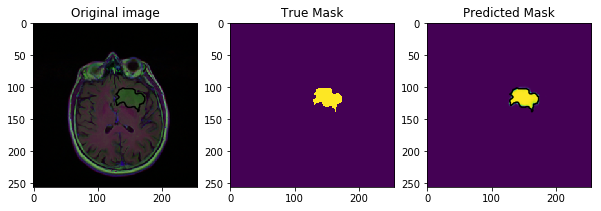

In [52]:
print_image_and_masks(X_train, 9)

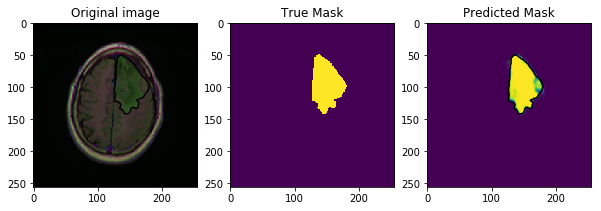

In [53]:
print_image_and_masks(X_train, 559)

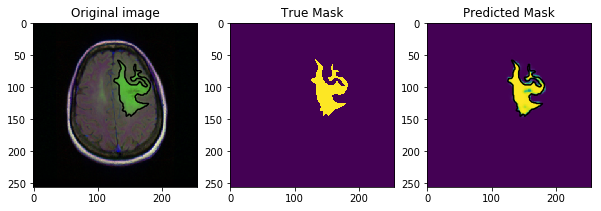

In [61]:
print_image_and_masks(X_val, 7)